In [1]:
# Imports
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import torch as torch
from torch import nn
from nltk.tokenize import word_tokenize
import math as mt
import time
import random
from joblib import Parallel, delayed
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import shuffle
print("Done")

Done


## Load model

In [2]:
class Word2Vec(nn.Module):
    def __init__(self, features, embedding_size):
        super().__init__()
        initrange = 0.5 / embedding_size
        self.fc1 = nn.Linear(features, embedding_size)
        self.fc2 = nn.Linear(embedding_size, features)


    def forward(self, one_hot):
        x = self.fc1(one_hot.float())
        x = self.fc2(x)
        log_softmax = torch.nn.functional.log_softmax(x, dim=1)
        return log_softmax
#     pass

print("Done")

Done


## 

In [3]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
    
url = 'https://raw.githubusercontent.com/salmanedhi/NNTI-WS2021-NLP-Project/main/data/hindi_hatespeech.tsv'

data = pd.read_csv(url, sep='\t')
    
#data = pd.read_csv('data/hindi_hatespeech.tsv', sep='\t')
data_development = shuffle(data)
labels = data_development['task_2']
# data_development = data
type(data_development['task_1'])

print("Done", device)

Done cuda:0


## Stopword Removal

In [4]:
hindi_stopword_file = open('data/stopwords-hi.txt', encoding="utf8")

sw_list = ['#', '?', '!', ';', ',', ':', "\'", '-', '=', '(', ')', '[', ']' , '{', '}', '"', '*', '@', '  ', '\\', '/', '..', '...', '....', '%'
          ,'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '\t']
sw_list_string = ''
for i in sw_list:
    sw_list_string+=i
hindi_stopwords = []
for x in hindi_stopword_file:
    hindi_stopwords.append(x.rstrip())

hindi_stopwords.extend(sw_list)
sentences = []
for text in data_development['text']:
    text_array = text.split(' ')
    new_array = []
    for j in text_array:
        if '@' not in j and len(j) < 20:
            for char in sw_list:
                j = j.replace(char, '')
            new_array.append(j.lower())
    sentences.append(' '.join(new_array))

print("Done")

Done


## Build Vocab

In [5]:
#TODO: implement!
temp_unique = [] # For unique words
temp_nounique = []
for j in sentences:
    temp2 = j.split(' ')
    for k in temp2:
        if k not in temp_unique:
            temp_unique.append(k)
        temp_nounique.append(k)
V = temp_unique
non_unique = temp_nounique
print('Total words:', len(non_unique))
print('Unique words:', len(V))

Total words: 141550
Unique words: 19836


In [6]:
model = Word2Vec(19836, 600)
model.load_state_dict(torch.load('model_param_finalised'))
print(model.eval())
weights1 = torch.transpose(model.fc1.weight, 0, 1)
weights2 = torch.transpose(model.fc2.weight, 0, 1)
temp_row = np.zeros(600).reshape(1,600)
weights1_np = weights1.cpu().detach().numpy()
weights1_np = np.concatenate((temp_row, weights1_np), axis=0)
weights1 = torch.Tensor(weights1_np)
print(weights1.shape, weights2.shape)

Word2Vec(
  (fc1): Linear(in_features=19836, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=19836, bias=True)
)
torch.Size([19837, 600]) torch.Size([600, 19836])


In [7]:
#TODO: implement!
def word_to_one_hot(word, features):
    if word in V:
        index = V.index(word)
        encoding = np.zeros(features)
        encoding[index]= 1
        return encoding.astype(np.uint8)
    return False

def not_word_to_one_hot(word, features):
    if word in V:
        index = V.index(word)
        return index
    return False

def index_to_onehot(X_batch):
    X_batch_new = []
    y_batch_new = []
    encodingX = np.eye(4)[X_batch]
    return type(encodingX)

def sentence_to_index(sentence):
    words = sentence.split(' ')
    l = []
    for i in words:
        l.append(V.index(i) + 1)
    return l, len(l)
#     return l

def padding(array, seq_len):
    padded_array = []
    for item in array:
        if len(item) < seq_len:
            padded_array.append([0]*(seq_len-len(item)) + item)
        else:
            padded_array.append(item)
    return np.array(padded_array)
            
#     for review in encoded_reviews:
#         if len(review) >= seq_length:
#             reviews.append(review[:seq_length])
#         else:
#             reviews.append([0]*(seq_length-len(review)) + review)
        
#     return np.array(reviews)

print(sentence_to_index(sentences[0]))
print(labels)

([1, 2, 3, 4, 5, 6, 3, 7, 8, 3, 9, 10, 11, 12, 13, 14, 15, 16, 17, 12, 18, 19, 19, 19, 20, 12, 21, 22, 19, 23, 24, 25, 26, 19, 19, 19, 19, 19, 19, 19], 40)
4153    PRFN
51      PRFN
1061    PRFN
3913    NONE
638     PRFN
        ... 
2918    PRFN
4213    OFFN
3306    NONE
3587    NONE
3003    HATE
Name: task_2, Length: 4665, dtype: object


## Create Dataset

In [8]:
x_data = []
max_len_curr = -1
for sentence in sentences:
    temp, max_len = sentence_to_index(sentence)
    if max_len > max_len_curr:
        max_len_curr = max_len
    x_data.append(temp)

# print(x_data)
padded = np.array(padding(x_data, max_len_curr))

# x_data = x_data.astype('float32')
# print(x_data.shape)
print(padded.shape)
encoded_labels = [0 if label == "NONE" else 1 for label in labels]
encoded_labels = np.array(encoded_labels)
print(encoded_labels)

(4665, 132)
[1 1 1 ... 0 0 1]


In [9]:
###############################################################################
##############  7. SPLIT DATA & GET (REVIEW, LABEL) DATALOADER  ###############
###############################################################################
train_ratio = 0.8
valid_ratio = (1 - train_ratio)/2
total = padded.shape[0]
train_cutoff = int(total * train_ratio)
valid_cutoff = int(total * (1 - valid_ratio))

train_x, train_y = padded[:train_cutoff], encoded_labels[:train_cutoff]
valid_x, valid_y = padded[train_cutoff : valid_cutoff], encoded_labels[train_cutoff : valid_cutoff]
test_x, test_y = padded[valid_cutoff:], encoded_labels[valid_cutoff:]
# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)
# print(valid_x.shape, valid_y.shape)
# train_x = torch.from_numpy(train_x)
train_data = TensorDataset(torch.tensor(train_x), torch.tensor(train_y))
valid_data = TensorDataset(torch.tensor(valid_x), torch.tensor(valid_y))
test_data = TensorDataset(torch.tensor(test_x), torch.tensor(test_y))

batch_size = 64
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True, drop_last=True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True, drop_last=True)
print("Done", padded.shape, valid_x.shape, train_x.shape)

Done (4665, 132) (466, 132) (3732, 132)


In [57]:
class SentimentLSTM(nn.Module):
    
    def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, drop_p = 0.5):
    
#     def __init__(self, cool):
        super().__init__()
        # params: "n_" means dimension
        self.n_vocab = n_vocab     # number of unique words in vocabulary
        self.n_layers = n_layers   # number of LSTM layers 
        self.n_hidden = n_hidden   # number of hidden nodes in LSTM
        
        self.embedding = nn.Embedding(n_vocab, n_embed)
        #embeddings is a torch tensor.
        self.embedding.weight = nn.Parameter(weights1, requires_grad = False)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, dropout = drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward (self, input_words):
                                             # INPUT   :  (batch_size, seq_length)
        embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
        lstm_out, h = self.lstm(embedded_words)         # (batch_size, seq_length, n_hidden)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden) # (batch_size*seq_length, n_hidden)
        fc_out = self.fc(lstm_out)                      # (batch_size*seq_length, n_output)
        sigmoid_out = self.sigmoid(fc_out)              # (batch_size*seq_length, n_output)
        sigmoid_out = sigmoid_out.view(batch_size, -1)  # (batch_size, seq_length*n_output)
#         print('HEre',input_words.shape)
        # extract the output of ONLY the LAST output of the LAST element of the sequence
        sigmoid_last = sigmoid_out[:, -1]               # (batch_size, 1)
        
        return sigmoid_last, h
    
    
    def init_hidden (self, batch_size):  # initialize hidden weights (h,c) to 0
        
#         device = "cuda" if torch.cuda.is_available() else "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        
        return h

In [58]:
n_vocab = len(V) + 1
n_embed = 600
n_hidden = 32
n_output = 1   # 1 ("positive") or 0 ("negative")
n_layers = 2
print(n_vocab, n_embed, n_hidden, n_output, n_layers)
net = SentimentLSTM(n_vocab, n_embed, n_hidden, n_output, n_layers)
net.to(device)
# net = SentimentLSTM(13)

19837 600 32 1 2


SentimentLSTM(
  (embedding): Embedding(19837, 600)
  (lstm): LSTM(600, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [59]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, amsgrad=True)

In [60]:
print_every = 100
step = 0
n_epochs = 100  # validation loss increases from ~ epoch 3 or 4
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# if torch.cuda.is_available():
#     device = "cuda:0"
# else:
#     device = "cpu"
# print(device)

training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
#         print(i, inputs.shape, labels.shape)
        # making requires_grad = False for the latest set of h
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
        if (step % print_every) == 0:            
            ######################
            ##### VALIDATION #####
            ######################
            net.eval()
            valid_losses = []
            v_h = net.init_hidden(batch_size)
            
            for v_inputs, v_labels in valid_loader:
                v_inputs, v_labels = inputs.to(device), labels.to(device)
        
                v_h = tuple([each.data for each in v_h])
                
                v_output, v_h = net(v_inputs)
                v_loss = criterion(v_output.squeeze(), v_labels.float())
                valid_losses.append(v_loss.item())

            print("Epoch: {}/{}".format((epoch+1), n_epochs),
                  "Step: {}".format(step),
                  "Training Loss: {:.4f}".format(loss.item()),
                  "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
            net.train()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))
    
print("Done")

<ipython-input-60-2801870d6992>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/100 Training Loss: 0.6923
Epoch: 2/100 Step: 100 Training Loss: 0.6937 Validation Loss: 0.7014
Epoch: 2/100 Training Loss: 0.6830
Epoch: 3/100 Training Loss: 0.6730
Epoch: 4/100 Step: 200 Training Loss: 0.6545 Validation Loss: 0.6570
Epoch: 4/100 Training Loss: 0.6666
Epoch: 5/100 Training Loss: 0.6589
Epoch: 6/100 Step: 300 Training Loss: 0.6849 Validation Loss: 0.6890
Epoch: 6/100 Training Loss: 0.6467
Epoch: 7/100 Step: 400 Training Loss: 0.6588 Validation Loss: 0.6478
Epoch: 7/100 Training Loss: 0.6353
Epoch: 8/100 Training Loss: 0.6286
Epoch: 9/100 Step: 500 Training Loss: 0.6249 Validation Loss: 0.6231
Epoch: 9/100 Training Loss: 0.6040
Epoch: 10/100 Training Loss: 0.5897
Epoch: 11/100 Step: 600 Training Loss: 0.5132 Validation Loss: 0.5042
Epoch: 11/100 Training Loss: 0.5760
Epoch: 12/100 Training Loss: 0.5549
Epoch: 13/100 Step: 700 Training Loss: 0.5527 Validation Loss: 0.5450
Epoch: 13/100 Training Loss: 0.5422
Epoch: 14/100 Step: 800 Training Loss: 0.6638 Validation

100


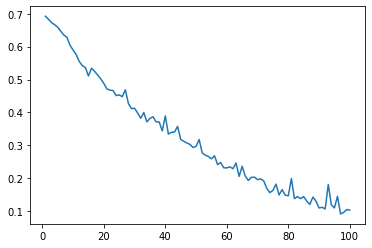

In [62]:
print(len(training_loss_epoches))
plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
torch.save(net, 'model_task2')
torch.save(net.state_dict(), 'model_param_task2')

In [ ]:
net.load_state_dict(torch.load('model_param_task2'))
net.to(device)

## Test set

In [63]:
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
net.eval()

test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device))
    except IndexError:
        print(inputs)
#     print(labels.dtype, test_output.dtype)
#     print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 1.4219
Test Accuracy: 0.68


In [12]:
print(len(test_y) - np.sum(test_y))
print(np.sum(test_y))
print(len(encoded_labels))
print(np.sum(encoded_labels))

219
248
4665
2469
